# Bird Box
Helping drone detects bird in the field of view, and potentially draw a plan to avoid it in advance.

Bird categorizing task can be improved as much as 14% in accuracy via getting rid of background portion (using only part inside the bounding box of an image) [source](https://towardsdatascience.com/this-model-is-for-the-birds-6d55060d9074)



In [1]:
# importing stuffs
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
sns.set()

In [ ]:
# https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
# This block to fix error:
# TensorFlow: Blas GEMM launch failed
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [2]:
# data source: NABirds data set provided by the Cornell Lab of Ornithology
# https://dl.allaboutbirds.org/nabirds
# https://www.birds.cornell.edu/home
# file_path = r'E:\Download\nabirds.tar\nabirds'
file_path = r'C:\Users\pui_s\Downloads\nabirds.tar\nabirds'
images = pd.read_csv(file_path + r'\images.txt', delimiter=' ', header=None)
images = images.rename({i:['id', 'image'][i] for i in range(2)}, axis='columns')
images['image'] = file_path + r'/images/' + images['image']
images

,id,image
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...
2,00019306-9d83-4334-b255-a447742edce3,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...
3,0001afd4-99a1-4a67-b940-d419413e23b3,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...
4,000332b8-997c-4540-9647-2f0a8495aecf,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...
...,...,...
48557,fff86e8b-795f-400a-91e8-565bbb8c453a,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...
48558,fff926d7-ccad-4788-839e-97af2dd99372,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...
48559,fffa33ef-a765-408d-8d66-6efc7f504c71,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...


In [11]:
images.iloc[0].image

'C:\\Users\\pui_s\\Downloads\\nabirds.tar\\nabirds/images/0817/0000139e21dc4d0cbfe14cae3c85c829.jpg'

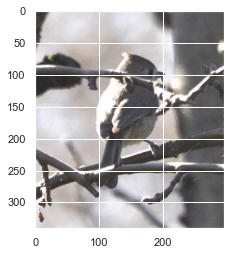

In [5]:
# plotting image
image_object = mpimg.imread(images.image.loc[0])
plt.imshow(image_object)
plt.show()

In [3]:
# reading bounding box data 
bound_box = pd.read_csv(file_path + r'\bounding_boxes.txt', delimiter=' ', header=None)
bound_box = bound_box.rename({i:['id', 'x', 'y', 'width', 'height'][i] for i in range(len(bound_box.columns))}, axis='columns')
bound_box

,id,x,y,width,height
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,83,59,128,228
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,328,88,163,298
2,00019306-9d83-4334-b255-a447742edce3,174,367,219,378
3,0001afd4-99a1-4a67-b940-d419413e23b3,307,179,492,224
4,000332b8-997c-4540-9647-2f0a8495aecf,395,139,262,390
...,...,...,...,...,...
48557,fff86e8b-795f-400a-91e8-565bbb8c453a,344,163,291,472
48558,fff926d7-ccad-4788-839e-97af2dd99372,330,180,339,671
48559,fffa33ef-a765-408d-8d66-6efc7f504c71,184,94,258,612
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce,102,210,461,688


In [4]:
bird_df = pd.merge(images, bound_box, how='inner', on='id') # merging on id to ensure data from both tables merged correctly
bird_df

,id,image,x,y,width,height
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...,83,59,128,228
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...,328,88,163,298
2,00019306-9d83-4334-b255-a447742edce3,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...,174,367,219,378
3,0001afd4-99a1-4a67-b940-d419413e23b3,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...,307,179,492,224
4,000332b8-997c-4540-9647-2f0a8495aecf,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...,395,139,262,390
...,...,...,...,...,...,...
48557,fff86e8b-795f-400a-91e8-565bbb8c453a,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...,344,163,291,472
48558,fff926d7-ccad-4788-839e-97af2dd99372,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...,330,180,339,671
48559,fffa33ef-a765-408d-8d66-6efc7f504c71,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...,184,94,258,612
48560,ffff0d87-bc84-4ef2-a47e-a4bfa48502ce,C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...,102,210,461,688


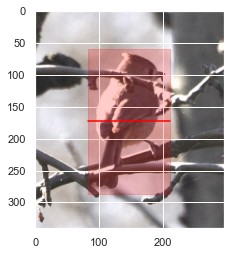

In [5]:
# plotting image with its bounding box
# idx = np.random.randint(low=0, high=len(bird_df))
# print('iloc: ', idx)
idx = 0
image_object = mpimg.imread(bird_df.image.iloc[idx])
plt.imshow(image_object)
x = [bird_df.iloc[idx]['x'], bird_df.iloc[idx]['x']+bird_df.iloc[idx]['width']]
y = [bird_df.iloc[idx]['y'], bird_df.iloc[idx]['y']+bird_df.iloc[idx]['height']]
sns.lineplot(x=[x[0], x[0], x[1], x[1]], y=[y[0], y[1], y[0], y[1]], color='red')
plt.show()

In [57]:
# will extract only those in 0817 folder for quick training 
# on a pretrained neural network
idx_0817 = []
s_temp = bird_df.image.str.split('/')
for each in bird_df.index:
    if '0817' in s_temp[each]:
        t=idx_0817.append(each)

48561

In [105]:
bird_df.loc[idx_0817].iloc[0]

id                     0000139e-21dc-4d0c-bfe1-4cae3c85c829
image     C:\Users\pui_s\Downloads\nabirds.tar\nabirds/i...
x                                                        83
y                                                        59
width                                                   128
height                                                  228
Name: 0, dtype: object

In [116]:
max(bird_df.height.max(), bird_df.width.max())

1024

In [145]:
# retreiving format for labelling
with open('template.xml', 'r') as f:
    out = f.readlines()
f.close()
out
temp_xml = out[:]
print(''.join(temp_xml))

<annotation>
	<folder>0817</folder>
	<filename>0000139e21dc4d0cbfe14cae3c85c829.jpg</filename>
	<path>C:\Users\pui_s\Downloads\nabirds.tar\nabirds\images\0817\0000139e21dc4d0cbfe14cae3c85c829.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>296</width>
		<height>341</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>bird</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>83</xmin>
			<ymin>59</ymin>
			<xmax>211</xmax>
			<ymax>287</ymax>
		</bndbox>
	</object>
</annotation>



In [166]:
# looping through all the images in 0817 folder
for idx in idx_0817:
    temp_df = bird_df.loc[idx]
    file_name = temp_df.image.split('/')[-1]
    newFileName = file_name.split('.')[0]+'.xml'
    x, y = temp_df.x, temp_df.y
    w, h = temp_df.width, temp_df.height
    file_path = temp_df.image.replace('/', '\\').encode('unicode_escape').decode('ascii') # to ignore escape \U
    image_object = mpimg.imread(temp_df.image)
    height, width = image_object.shape[:2]
    
    
    # x and y coordinates
    assert w > 0 and h > 0
    temp_xml[-7] = re.sub(r'(?<=<xmin>)(.*)(?=</xmin>)', str(x), temp_xml[-7])
    temp_xml[-6] = re.sub(r'(?<=<ymin>)(.*)(?=</ymin>)', str(y), temp_xml[-6])
    temp_xml[-5] = re.sub(r'(?<=<xmax>)(.*)(?=</xmax>)', str(x+w), temp_xml[-5])
    temp_xml[-4] = re.sub(r'(?<=<ymax>)(.*)(?=</ymax>)', str(y+h), temp_xml[-4])

    # width and height
    temp_xml[8] = re.sub(r'(?<=<width>)(.*)(?=</width>)', str(width), temp_xml[8])
    temp_xml[9] = re.sub(r'(?<=<height>)(.*)(?=</height>)', str(height), temp_xml[9])

    # file path
    temp_xml[3] = re.sub(r'(?<=<path>)(.*)(?=</path>)', file_path, temp_xml[3])

    # file name
    temp_xml[2] = re.sub(r'(?<=<filename>)(.*)(?=</filename>)', file_name, temp_xml[2])

#     print(''.join(temp_xml))
    
    # saving the xml file
    print('saving: ' + '0817_labels\\' + newFileName)
    out_f = open('0817_labels\\' + newFileName, "w")
    out_f.write(''.join(temp_xml))
    out_f.close()
#     break

saving: 0817_labels\0000139e21dc4d0cbfe14cae3c85c829.xml
saving: 0817_labels\01a472d8e93047a080aae4f958a2ef47.xml
saving: 0817_labels\036fba7c96374635853511ead2c1c728.xml
saving: 0817_labels\07814887f59b44cb9b7f399999634fba.xml
saving: 0817_labels\0822865741de43128a6a6c8897387975.xml
saving: 0817_labels\0b277615eb6e499da2fc26525aa6e60e.xml
saving: 0817_labels\110f7a2a05cd488fb15425588f75b80e.xml
saving: 0817_labels\148631327cc44e1caebe38671d1b54c0.xml
saving: 0817_labels\15118d82ede04508b25309ea9854a659.xml
saving: 0817_labels\16da4080692342d28d3fa9328cab8c0a.xml
saving: 0817_labels\19f1ceead89e4191ab362c096de940c8.xml
saving: 0817_labels\1a68d370bb664fa8b761c3fc3f6e417c.xml
saving: 0817_labels\1d04afaa687443f5a5dac6f5deebd45b.xml
saving: 0817_labels\2033ce2dc2e84cc5ba1f86944124cccb.xml
saving: 0817_labels\223a4eec9f8b42099126f33a78c08783.xml
saving: 0817_labels\2d5dedcefc0e4ff9841450c32b3d3466.xml
saving: 0817_labels\2d6cbc1bade24df5984547b9f92fb51b.xml
saving: 0817_labels\2d9d025b88c

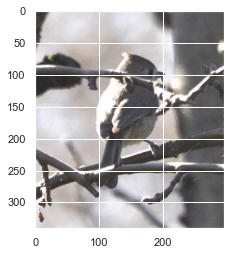

In [136]:
idx = 0
this_bird = bird_df.loc[idx_0817[idx]]
image_object = mpimg.imread(this_bird.image)
plt.imshow(image_object)

In [117]:
# using EfficientDet

In [118]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
Updating files:  57% (1480/2584)
Updating files:  58% (1499/2584)
Updating files:  59% (1525/2584)
Updating files:  60% (1551/2584)
Updating files:  61% (1577/2584)
Updating files:  62% (1603/2584)
Updating files:  63% (1628/2584)
Updating files:  64% (1654/2584)
Updating files:  65% (1680/2584)
Updating files:  66% (1706/2584)
Updating files:  67% (1732/2584)
Updating files:  68% (1758/2584)
Updating files:  69% (1783/2584)
Updating files:  70% (1809/2584)
Updating files:  71% (1835/2584)
Updating files:  72% (1861/2584)
Updating files:  73% (1887/2584)
Updating files:  74% (1913/2584)
Updating files:  75% (1938/2584)
Updating files:  76% (1964/2584)
Updating files:  77% (1990/2584)
Updating files:  78% (2016/2584)
Updating files:  79% (2042/2584)
Updating files:  80% (2068/2584)
Updating files:  81% (2094/2584)
Updating files:  82% (2119/2584)
Updating files:  83% (2145/2584)
Updating files:  84% (2171/2584)
Updating files:  85% (2197/2584)
Updating files:  8

In [139]:
%%bash
# Install the Object Detection API

cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Couldn't find program: 'bash'


In [130]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf


from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

ImportError: cannot import name 'string_int_label_map_pb2' from 'object_detection.protos' (C:\Users\pui_s\Documents\concordia-bootcamps\FinalProject-BirdBox\BirdBox_helping_drone_detect_bird\models\research\object_detection\protos\__init__.py)

In [126]:
import sys
sys.path
if r'C:\Users\pui_s\Documents\concordia-bootcamps\FinalProject-BirdBox\BirdBox_helping_drone_detect_bird\models\research' not in sys.path:
    sys.path.insert(0, r'C:\Users\pui_s\Documents\concordia-bootcamps\FinalProject-BirdBox\BirdBox_helping_drone_detect_bird\models\research')

In [128]:
sys.path

['C:\\Users\\pui_s\\Documents\\concordia-bootcamps\\FinalProject-BirdBox\\BirdBox_helping_drone_detect_bird\\models\\research',
 'C:\\Users\\pui_s\\Documents\\concordia-bootcamps\\FinalProject-BirdBox\\BirdBox_helping_drone_detect_bird',
 'C:\\Users\\pui_s\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip',
 'C:\\Users\\pui_s\\AppData\\Local\\Programs\\Python\\Python39\\DLLs',
 'C:\\Users\\pui_s\\AppData\\Local\\Programs\\Python\\Python39\\lib',
 'C:\\Users\\pui_s\\AppData\\Local\\Programs\\Python\\Python39',
 '',
 'C:\\Users\\pui_s\\AppData\\Roaming\\Python\\Python39\\site-packages',
 'C:\\Users\\pui_s\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32',
 'C:\\Users\\pui_s\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32\\lib',
 'C:\\Users\\pui_s\\AppData\\Roaming\\Python\\Python39\\site-packages\\Pythonwin',
 'C:\\Users\\pui_s\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages',
 'C:\\Users\\pui_s\\AppData\\Roaming\\Python\\Python39\\site-packages

In [ ]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [142]:
!py -m pip list

Package                  Version
------------------------ -------------------
absl-py                  0.12.0
anyio                    3.2.0
argon2-cffi              20.1.0
astor                    0.8.1
astunparse               1.6.3
async-generator          1.10
attrs                    21.2.0
autograd                 1.3
autograd-gamma           0.5.0
Babel                    2.9.1
backcall                 0.2.0
bash_kernel              0.7.2
beautifulsoup4           4.9.3
bleach                   3.3.0
bs4                      0.0.1
cachetools               4.2.2
certifi                  2020.12.5
cffi                     1.14.5
chardet                  3.0.4
Christofides             1.0.1
click                    8.0.1
colorama                 0.4.4
configparser             5.0.2
cycler                   0.10.0
Cython                   0.29.24
decorator                4.4.2
defusedxml               0.7.1
dload                    0.6
entrypoints              0.3
fake-useragent     